# CAshflow Optimization System


## 1 Description

CAOS is a prototype simulation-based decision support system for cash-flow planning. It has been developed using the UPF (Unified Planning Framework) provided by AIPlan4EU. It is designed to help users manage their transactions with multiple vendors and clients but also provide insight for further negotiations. Based on user input, the system generates and evaluates a large number of scenarios that aim to represent possible negotiation outcomes. The evaluation results are post-processed and provided as a feedback to the user so as to help with any upcoming negotiations. Once a negotiation is finalized, the user is able to input the finalized negotiation details back to the system, and progress to the next planning period. 

## 2 Architecture

Overall, the CAOS TSB consists of four interconnected modules : a) Interest Rate Prediction Module, b) Scenario Generation Module, c) Planning Module and d) Plan Evaluation Module. In short, based on user input, multiple payment planning scenarios are generated using interest rate information provided by the interest rate prediction module. The generated scenarios are converted to PDDL models using the UPF framework and solved using dedicated PDDL solvers (such as the ENH-SP solver). Lastly, simulation results are post-processed from the post processing module and the recommended actions are provided to the end-user. In the following sections more details about each individual module are provided.


### 2.1 Interest Rate Prediction Module

The interest rate prediction module is a standalone module that aims to simulate the behavior of counterparties during negotiations as accurately as possible. More specifically, the module is responsible for estimating the acceptance probability for proposed deferral dates of payments or proposed interest rates of payments that may be suggested to a counterparty. To that end, complicated behavioral models could possibly make the simulation intractable and thus, within CAOS we adopt a simpler yet very robust methodology to model the behavior of all counterparties. This is achieved by adopting parametric probability distributions. Every counterparty is characterized by a unique probability distribution that reflects a more personalized behavior. For that purpose, every counterparty is identified by a set of parameters that are used to control the parametric probability distributions. In the following sections, we present these parameters but also the way they are interpreted in the behavioral model of counterparties within CAOS.

#### 2.1.1 Negotiation Openness

Different counterparties, may adopt different policies with regards to entering a negotiation. In other words, there may be a high variance when it comes to the openness to negotiation of different counterparties. In CAOS, a parameter $0 \leq \delta \leq 1$ is used as a threshold to describe this behavior. The higher the value of $\delta$, the higher the probability for a counterparty to enter negotiations.

#### 2.1.2 Interest Rate Acceptance Behavior

The acceptance probability of interest rates is modelled using the cumulative distribution function of the logistic distribution, i.e., the logistic function.

$$F^I(x,\alpha,\beta) = \frac{1}{1 + e^{-\alpha(x-\beta)}}$$


In the above equation, parameters $\alpha$ and $\beta$ control the shape of the curve, while $x$ represents an interest rate. More specifically, parameter α controls the logistic growth, or the steepness of the curve, while parameter β controls the mid-point of the function. This curve acts as a realistic simulator of the behavior of any counterparty as it is expected by any party to accept very low interest rates with a high probability. On the other hand, as the interest rate increases, there is a region that the counterparty may accept an interest rate with a probability of less than 100%, while beyond a rate threshold it is very unlikely to accept any rate.

For every counterparty, two set of parameters are defined so as to allow for a distinct behavior on inbound and outbound transactions. In the following, we visualize the acceptance probability of a range of interest rates for a set of clients for both inbound and outbound payments. 

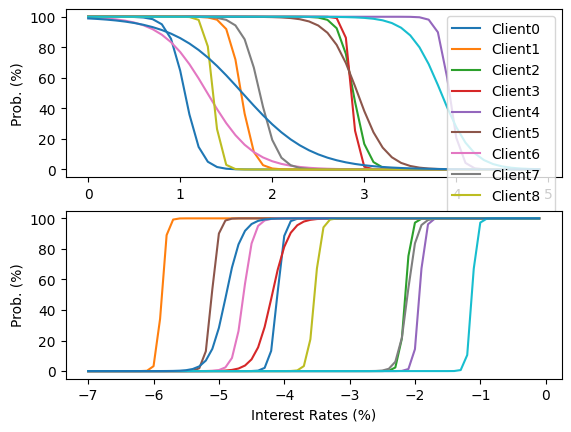

In [2]:
from problem import CAOSProblem
from common import ContractType

from interest_rate_prediction import InterestRatePrediction
import matplotlib.pyplot as plt

### Create problem object and load data
p = CAOSProblem()
#p.CreateRandomInstance()
p.LoadInstance("gen_data.json")

f, ax = plt.subplots(2,1)


#Inbound Probabilities
x = [v * 0.1 for v in range(0, 50)]

for c in p.clients:
    y = [InterestRatePrediction.FindRateProbability(c, ContractType.INBOUND, v) * 100 for v in x]
    ax[0].plot(x, y, label=c.name)

#Outbound Probabilities
x = [v * 0.1 for v in range(-70, 0)]

for c in p.clients:
    y = [InterestRatePrediction.FindRateProbability(c, ContractType.OUTBOUND, abs(v)) * 100 for v in x]
    ax[1].plot(x, y, label=c.name)


ax[1].set_xlabel("Interest Rates (%)")
ax[0].set_ylabel("Prob. (%)")
ax[1].set_ylabel("Prob. (%)")
ax[0].legend()
plt.show()

#### 2.1.3 Max Deferral Date

An important characteristic of a counterparty that should be taken into account during negotiations, is the financial flexibility. In other words, how flexible a counterparty is so as to defer inbound or outbound payments back and forth within the planning horizon. Counterparties with tight budget and short-term planning, are very likely to avoid long term negotiations that may hurt their day to day balance, while others may be more flexible and open to negotiate in a wider planning horizon. Wihtin CAOS, a parameter $\epsilon$ is used to describe the length of the maximum time range that a counterparty is willing to defer its payments (inbound or outbound). The higher the value, the longer the deferral of an inbound or outbound payment may be compared to its original due date.


#### 2.1.4 Deferral Date Acceptance

Regardless of how flexible or not a counterparty is, it is of crucial important to estimate the probability of acceptance of a counterparty with respect to a proposed deferral date for a payment. For this purpose the acceptance probability of a deferral date is modelled within CAOS using a paremetric asymptotic function. A parameter is used to control the incline of the function that represents the rate of decline for larger payment deferral periods. 

The general form of the probability function is:

$$ F^D(x, \gamma) = \frac{\gamma}{x - p_1} + p_2$$

where $p_1, p_2$ are parameters can be calculated as functions of $\epsilon$ and $\gamma \in (0, \frac{\epsilon + 1}{4})$. 



More specifically, for inbound payments $p_1$ and $p_2$ can be calculated as follows:

$$ p_1 = \frac{(1 + \epsilon) \pm \sqrt{(1 + \epsilon)^2 + 4\gamma(\epsilon + 1)}}{2}$$
$$ p_2 = 1 + \frac{\gamma}{p_1}$$

In the case of outbound payments, $p_1$ and $p_2$ can be calculated as follows:

$$ p_1 = \frac{(-1 - \epsilon) \pm \sqrt{(1 + \epsilon)^2 + 4\gamma(\epsilon + 1)}}{2}$$
$$ p_2 = 1 - \frac{\gamma}{p_1}$$


In the following, we visualize the acceptance probability for a range of deferral dates (in periods) for a set of clients for both types of payments.

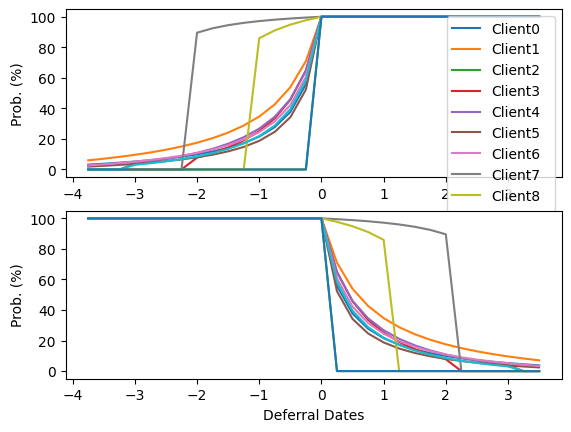

In [2]:
from interest_rate_prediction import InterestRatePrediction
import matplotlib.pyplot as plt


f, ax = plt.subplots(2,1)

x = [v * 0.25 for v in range(-15, 15)]

#Inbound
for c in p.clients:
    y = [InterestRatePrediction.FindDeferralProbabilityInbound(c, p) * 100 for p in x]
    ax[0].plot(x, y, label=c.name)

x = [v * 0.25 for v in range(-15, 15)]

#Outbound
for c in p.clients:
    y = [InterestRatePrediction.FindDeferralProbabilityOutbound(c, p) * 100 for p in x]
    ax[1].plot(x, y, label=c.name)


ax[1].set_xlabel("Deferral Dates")
ax[0].set_ylabel("Prob. (%)")
ax[1].set_ylabel("Prob. (%)")
ax[0].legend()
plt.show()

### 2.2 Scenario Generation Module

The aim of the Scenario Generation module is to generate a wide range of realistic planning scenarios where the stochastic information regarding the current but also future negotiations is fixed.

At first, since the goal is to assist the end user for the negotiations of the current time period, the scenario generation module focuses on the earliest payments in the planning horizon. The advantages of this approach are two-fold: a) there is no need to generate any scenarios (and therefore waste useful time and resources) for all payments of the entire planning horizon and b) the real outcome of the negotiation to inform and improve the system prior to the next evaluation and therefore increase the accuracy and reliability of the system for the next iteration.

For the selected payments, the Scenario Generation module will iterate over a selected range of interest rates, a selected range of the possible number of installments and generates several alternative scenarios. Both the interest rate range, the number of installments but also the number of alternatives to generate are part of the system configuration. Every scenario is generated in three main steps:

* Step 1: A selected interest rate is imposed to the examined payment.
* Step 2: A selected number of installments for the payment.
* Step 2a: In the case of a single installment, select a deferral date for the payment
* Step 3: Find an acceptable rate for all the remaining counterparties.
* Step 4: Calculate scenario probability.


The study of a wide range of interest rates per counterparty seems an overkill. However, it allows us to make a comprehensive search on scenarios that may not be very probable but may be very profitable for the user and therefore, provide insight for future decisions. The process of finding an acceptable rate for the remaining counterparties in Step 3, is a monte carlo experiment. More specifically, the range of interest rates is uniformly sampled and a candidate rate is selected. Subsequently, for this rate the acceptance probability is calculated. The acceptance probabilities are also calculated by the interest rate prediction module. 

The probability of the generated scenario probability calculated at Step 4, is the combined probability of all the selected rates. It can be calculated as the product of all individual acceptance probabilities. Assuming that, $x_1,x_2,…,x_{n-1},x_n$, are the selected rates for all counterparties, then the scenario probability $p^s$ can be calculated as:

$$p^s=p(x_1 )p(x_2 )⋯p(x_{n-1})p(x_n)$$

The output of the generation process is a Scenario object that can be converted to a *PlanningProblem* object. Subsequently, such objects can be directly by the planning module to obtain the corresponding solution in the form of a *PlanningSolution* object. 



### 2.3 Planning Module


The Planning Module of the CAOS TSB is responsible for simulating operational scenarios and generate an optimal schedule for all the pending transactions. This module utilizes the Unified Planning (UP) framework to convert a generated scenario into a PDDL model, which is solved using the Enhsp solver (TODO: add reference to the enhsp solver).


### 2.3.1 Problem Description

The planning problem that is solved using the UP framework given a scenario can be defined as follows: There is a set of inbound and outbound payments, $IP$ and $OP$, respectively. All payments have to be completed within a pre-determined planning horizon with duration $T$, while there is also a start balance denoted by $S$. Every payment $i \in IP \cup OP$ is associated with an interest rate $r_i$ that is used to calculate the adjusted payment amount when the payment is completed on an earlier or later period. We also assume that a bank credit line is available at any time. This can be used when the cash inflow is not enough to complete payments towards vendors. To that end, when the net balance for a particular time period is negative, this implies that a specific amount of money should be loaned from the credit line with a particular interest rate. The loan interest rate is also part of the system configuration. The goal is to schedule all inbound and outbound payments so that the net balance at the end of the planning horizon is maximized while in parallel minimizing the total credit line charge.

In the following sections, we provide the required objects required for modeling the planning problem using the UPF framework. The module uses the enhsp-opt solver as it is one of the very few available solvers that support the necessary variable types but also the optimization objectives.



### 2.3.2 User Types


| User Type | Description |
| :- | :- |
| Period | A user type that denotes a period of the planning horizon |
| InContract | A user type that denotes an inbound contract |
| OutContract | A user type that denotes an outbound contract |


### 2.3.3 Fluents

| Fluent Name | Type | Parameter User Type(s) | Description |
| :- | :-: | :-: | :- |
| Start Balance At | Int | Period | A fluent that holds the balance at the start of a particular period |
| Final Balance At | Int | Period | A fluent that holds the balance at the end of a particular period |
| InboundData | Int | Period, InContract | A constant fluent that holds the payment amount of an inbound contract on a specific period |
| OutBoundData | Int | Period, OutContract | A constant fluent that holds the payment amount of an outbound contract on a specific period |
| InContractStatus | Bool | InContract | A fluent that holds the negotiation status of an inbound contract |
| OutContractStatus | Bool | OutContract | A fluent that holds the negotiation status of an outbound contract |
| ConnectedPeriods | Bool | Period, Period | A static fluent that determines the connectivity of period variables. The values of this fluent are initialized so that each period is connected only to its previous and next periods in the planning horizon |
| CurrentPeriod | Bool | Period | A fluent that holds the active period |



### 2.3.4 Actions

| Action Name | Action Parameter(s) | Description | Preconditions | Effects |
| :- | :-: | :- | :- | :- |
| AcceptPayment | Period, InContract | An action that credits a specified amount on the end-user’s balance at the related period when applied. | <ul><li>The related contract should not have been completed, i.e. InContractStatus(*InContract*)==False.</li></ul> | <ul><li>The related contract is marked as completed, i.e. $InContractStatus(InContract) = True$</li><li>The end user balance at the corresponding period is credited accordingly, i.e., $FinalBalanceAt(Period) = FinalBalanceAt(Period) + InboundData(Period, InContract)$</li></ul> |
| PayContract | Period, OutContract | An action that removes a specified amount from the end-user’s balance at the related period when applied. | <ul><li>The related contract should not have been completed, i.e. OutContractStatus(*OutContract*)==False.</li></ul> | <ul><li>The related contract is marked as completed, i.e., $OutContractStatus(OutContract) = True$</li><li>The end user balance at the corresponding period is reduced accordingly, i.e., $FinalBalanceAt(Period) = FinalBalanceAt(Period) - OutboundData(Period, OutContract)$</li></ul> |
| AdvancePeriod | FromPeriod, ToPeriod | An action that makes the transition between the *FromPeriod* to *ToPeriod* period. | <ul><li>*FromPeriod* and *ToPeriod* periods, should be connected, i.e., ConnectedPeriods(*FromPeriod*, *ToPeriod*) == True.</li><li>*FromPeriod* should be the current period, i.e., CurrentPeriod(*FromPeriod*) == True. </li></ul> | <ul><li> The start and final balance of *ToPeriod* is set to $LoanRate \cdot FinalBalanceAt(FromPeriod)$ if and only if the $FinalBalanceAt(FromPeriod) < 0$. </li> <li>The start and final balance of *ToPeriod* is set to $FinalBalanceAt(FromPeriod)$ if and only if the final balance of period FromPeriod is positive. </li></ul> |




### 2.4 Plan Evaluation Module

The Plan Evaluation module of the CAOS TSB is responsible for aggregating and evaluating the solutions generated by the Planning module for all the generated scenarios. The multiple scenarios are generated for the selected range of interest rates, number of installmanets and deferral dates on the payments of the earliest negotiations. At first, the module evaluates the scenario solutions by assigning a score to every scenario. Then, the average score of all evaluated scenarios is assigned to every combination of negotiation parameters (interest rate, number of installments and deferral date) for a specific payment.  Overall, there are three different policies supported by the module that determine the way that scenario scores are calculated:

* Policy A: Weighted Objective Accumulation
* Policy B: Best Objective Accumulation
* Policy C: Best Probability Accumulation

Based on policy A, the score of a scenario is calculated as the objective of the scenario solution weighted by the scenario probability. Using Policy B, the score is equal to the objective of the scenario’s planning solution, while with Policy C, it is equal to the probability of the scenario.

## Basic Usage

### Step 1 - Creating/Loading Data

The CAOS TSB allows for the manual entry of all the details and parameters of the planning problem.
In the following code snippet, you can see an example of the creation of a planning problem along with clients and some contracts and payments. 

In [5]:
from problem import CAOSProblem
from common import Client, Contract, Payment, ContractType

#Create Problem
p = CAOSProblem()

#Create two clients
c1 = Client("Client A", 0.45, 0.14)
c2 = Client("Client A", 0.25, 0.10)

#Create contracts and the corresponding payments for the clients
ctr_1 = Contract(ContractType.INBOUND, c1)
ctr_1_pmnt = Payment(ctr_1, 0, 1000)
ctr_2_pmnt = Payment(ctr_1, 1, 1000)
ctr_1.AddPayment(ctr_1_pmnt)
ctr_1.AddPayment(ctr_2_pmnt)

ctr_2 = Contract(ContractType.OUTBOUND, c2)
ctr2_pmnt = Payment(ctr_2, 1, 1500)
ctr_2.AddPayment(ctr2_pmnt)

#Add contracts to the problem object
p.AddContract(ctr_1)
p.AddContract(ctr_2)

#Report Problem
p.Report()



#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 2
### Total Contracts: 2
### Total CounterParties 0
#######################
### Inbound Contracts:
#	 ID: 038 	 Client: Client A 	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 000 	 Amount: 1000.00 	 Status: PaymentStatus.PENDING
#		 Period: 001 	 Amount: 1000.00 	 Status: PaymentStatus.PENDING
### Outbound Contracts
#	 ID: 039 	 Client: Client A 	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 1500.00 	 Status: PaymentStatus.PENDING
#######################


It is also possible to load data from a json file that includes all necessary information:


In [6]:
from problem import CAOSProblem
import json

#Load Data from json file
f = open("gen_data.json")
data = json.loads(f.read())
f.close()

# Create problem object and load data
p = CAOSProblem()
p.LoadInstance(data)

# Report
p.Report()

#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 11
### Total Contracts: 38
### Total CounterParties 11
#######################
### Inbound Contracts:
#	 ID: 040 	 Client: Client3  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 005 	 Amount: 4000.00 	 Status: PaymentStatus.PENDING
#	 ID: 041 	 Client: Client9  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 6000.00 	 Status: PaymentStatus.PENDING
#	 ID: 042 	 Client: Client7  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 000 	 Amount: 2000.00 	 Status: PaymentStatus.PENDING
#	 ID: 043 	 Client: Client0  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 008 	 Amount: 6000.00 	 Status: PaymentStatus.PENDING
#	 ID: 044 	 Client: Client1  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 005 	 Amount: 4000.00 	 Status: PaymentStatus.PENDING
#	 ID: 045 	 Client: Client6  	 Status: ContractStatus.UNDER_NEGOTIATION
#		 Period: 001 	 Amount: 5000.00 	 Status: 

### Step 2 - Generating Actions

Once problem data is set, the user can request actions from the service given the current state. This can be accomplised using the `GenerateActions` method of the `CAOSProblem`

In [5]:
p.GenerateActions()

AttributeError: 'Contract' object has no attribute 'period'

### Overall Problem Report

The user can get a report of the system using the ``Report()`` method. This method prints the current status of the system, including the current balance, the size of the planning horizon, the total number of contracts and clients but also a detailed report of inbound and outbound payments and their current status.


In [6]:
p.Report()

#######################
### Statistics
### Current Balance: 0
### Current Period: 0 / 11
### Total Contracts: 38
### Total CounterParties 11
#######################
### Inbound Contracts:
#	 ID: 038 	 Period: 005 	 Client: Client3  	 Amount: 4000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 039 	 Period: 001 	 Client: Client9  	 Amount: 6000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 040 	 Period: 000 	 Client: Client7  	 Amount: 2000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 041 	 Period: 008 	 Client: Client0  	 Amount: 6000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 042 	 Period: 005 	 Client: Client1  	 Amount: 4000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 043 	 Period: 001 	 Client: Client6  	 Amount: 5000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 044 	 Period: 008 	 Client: Client3  	 Amount: 6000.00 	 Type: ContractStatus.UNDER_NEGOTIATION
#	 ID: 045 	 Period: 001 	 Client: Client4  	 Amount: 1000.00 	 Type: ContractStatus.UNDER_

### Solve

In [7]:
p.Solve()

c:\Users\Greg\AppData\Local\Programs\Python\Python38-32\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '256680904651031/9007199254740992'
  warn(
c:\Users\Greg\AppData\Local\Programs\Python\Python38-32\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '5580021510963199/1099511627776'
  warn(
c:\Users\Greg\AppData\Local\Programs\Python\Python38-32\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '6696025813155839/1099511627776'
  warn(
c:\Users\Greg\AppData\Local\Programs\Python\Python38-32\lib\site-packages\unified_planning\io\pddl_writer.py:281: UserWarning: The PDDL printer cannot exactly represent the real constant '8928034417541119/8796093022208'
  warn(
c:\Users\Greg\AppData\Local\Programs\Python\Python38-32\lib\site-packages\unified_plan

## Results

In [8]:
p.PostProcess()


################
### Best Options for contract 40
### Policy 1
{'Deferral Periods': 1, 'Rate': 6.5, 'Weighted Objective': 0.0, 'Objective': 0.0, 'Installments': 1, 'Probability': 0.0}
### Policy 2
{'Deferral Periods': 1, 'Rate': 6.5, 'Weighted Objective': 0.0, 'Objective': 0.0, 'Installments': 1, 'Probability': 0.0}
### Policy 3
{'Deferral Periods': 4, 'Rate': 1.5, 'Weighted Objective': -1000.0, 'Objective': -1000.0, 'Installments': 1, 'Probability': 4.113667040911564e-06}
################
### Results saved to report.json
